In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, silhouette_score, silhouette_samples, davies_bouldin_score
)
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from xgboost import XGBClassifier
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.head()

,Month,Cbs district,City symbol,Name,City or Regional council,Total jobseekers,Men,Weman,Academic,Non academic,Hh,Unemployed job seekers,Placement from reference,Estimated unemployed rate in city
0,2010-01,אזור יהודה והשומרון,3760,אורנית,יישוב,83,34,49,36,47,4,83,2,2.22%
1,2010-01,אזור יהודה והשומרון,3750,אלפי מנשה,יישוב,88,38,50,26,62,5,88,4,2.18%
2,2010-01,אזור יהודה והשומרון,3560,אלקנה,יישוב,20,12,8,9,11,2,20,2,1.19%
3,2010-01,אזור יהודה והשומרון,3650,אפרתה,יישוב,48,28,20,18,30,8,48,5,1.37%
4,2010-01,אזור יהודה והשומרון,3570,אריאל,יישוב,410,189,221,111,299,156,410,16,4.12%


In [4]:
df = data.copy()
df.rename(columns={'Weman': 'Women'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28668 entries, 0 to 28667
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Month                              28668 non-null  object
 1   Cbs district                       28668 non-null  object
 2   City symbol                        28668 non-null  int64 
 3   Name                               28668 non-null  object
 4   City or Regional council           28668 non-null  object
 5   Total jobseekers                   28668 non-null  int64 
 6   Men                                28668 non-null  int64 
 7   Women                              28668 non-null  int64 
 8   Academic                           28668 non-null  int64 
 9   Non academic                       28668 non-null  int64 
 10  Hh                                 28668 non-null  int64 
 11  Unemployed job seekers             28668 non-null  int64 
 12  Plac

### Preprocessing - Handling missing values and convert dtypes

In [5]:
# Remove '%' and convert "Estimated unemployed rate in city" to numeric
df['Estimated unemployed rate in city'] = df['Estimated unemployed rate in city'].str.replace('%', '').astype(float)

# Handle missing data (drop rows with missing target values)
df = df.dropna(subset=['Estimated unemployed rate in city'])

# Create a target column for classification (high/low unemployment based on a threshold)
df['unemployment_rate_category'] = np.where(df['Estimated unemployed rate in city'] > df['Estimated unemployed rate in city'].median(), 1, 0)


In [6]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28620 entries, 0 to 28667
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Month                              28620 non-null  datetime64[ns]
 1   Cbs district                       28620 non-null  object        
 2   City symbol                        28620 non-null  int64         
 3   Name                               28620 non-null  object        
 4   City or Regional council           28620 non-null  object        
 5   Total jobseekers                   28620 non-null  int64         
 6   Men                                28620 non-null  int64         
 7   Women                              28620 non-null  int64         
 8   Academic                           28620 non-null  int64         
 9   Non academic                       28620 non-null  int64         
 10  Hh                                 2862

### Drop uncessary columns

In [8]:
df = df.drop(columns=['City symbol', 'Hh'])

We excluded the "Hh" column due to its unclear meaning and removed the "City symbol" column as it duplicates the information in the "Name" column, representing it numerically.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28620 entries, 0 to 28667
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Month                              28620 non-null  datetime64[ns]
 1   Cbs district                       28620 non-null  object        
 2   Name                               28620 non-null  object        
 3   City or Regional council           28620 non-null  object        
 4   Total jobseekers                   28620 non-null  int64         
 5   Men                                28620 non-null  int64         
 6   Women                              28620 non-null  int64         
 7   Academic                           28620 non-null  int64         
 8   Non academic                       28620 non-null  int64         
 9   Unemployed job seekers             28620 non-null  int64         
 10  Placement from reference           2862

### EDA

In [10]:
features_for_corr=['Total jobseekers', 'Men', 'Women', 'Academic', 'Non academic', 'Unemployed job seekers', 'Placement from reference','Estimated unemployed rate in city','unemployment_rate_category']
numerical_df = df[features_for_corr]
correlation_matrix = numerical_df.corr()

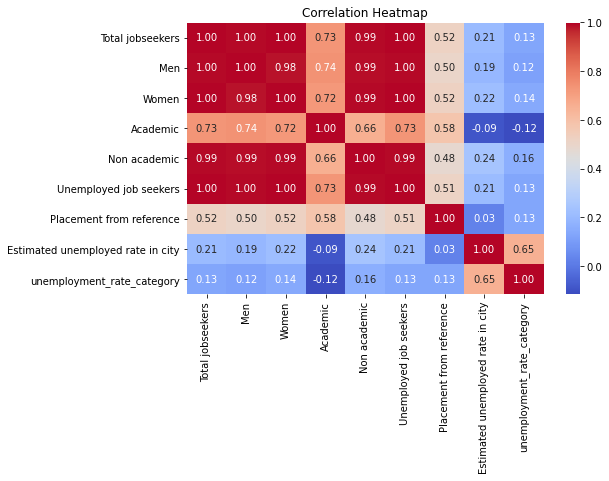

In [11]:
# Correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

#### drop columns:
Total jobseekers- high correlation with Men, Women (reasonale because its the sum of both) and Unemployed job seekers.

Unemployed job seekers- high correlation with Men, Women and Total jobseekers (reasonale because most of the jobseekrs are unemployed)

Despite the high correlation between the columns for Women, Men, and Non academic, we chose to retain the Non academic column as it may provide valuable insights for decision-makers, even if it has limited mathematical significance for the model's performance.

### Time Series

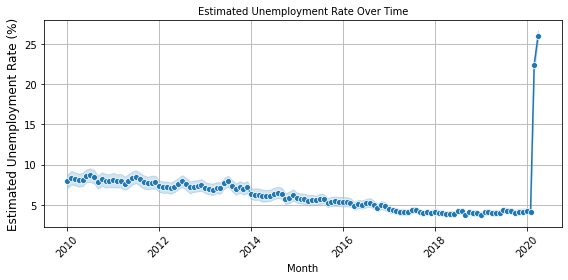

In [12]:
df_month = df.copy()
# Sort the data by 'month' for correct plotting
df_month=df_month.sort_values(by='Month')
# Plot the relationship
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x='Month', y='Estimated unemployed rate in city', marker='o')
plt.title('Estimated Unemployment Rate Over Time', fontsize=10)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Estimated Unemployment Rate (%)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

The plot shows a steady decline in unemployment from 2010 to 2019, with minor seasonal fluctuations. A sharp spike in 2020 likely reflects the COVID-19 pandemic. The long-term trends suggest that a Time Series model is appropriate, as it can analyze historical patterns and predict future changes accurately.
Therefore, we will not include the "Month" column in the model, as the data is sorted in chronological order.

In [13]:
df.tail()

,Month,Cbs district,Name,City or Regional council,Total jobseekers,Men,Women,Academic,Non academic,Unemployed job seekers,Placement from reference,Estimated unemployed rate in city,unemployment_rate_category
28663,2020-04-01,תל אביב,כפר שמריהו,יישוב,139,64,75,8,131,139,0,16.67,1
28664,2020-04-01,תל אביב,קריית אונו,יישוב,4076,1713,2363,350,3726,4061,1,20.71,1
28665,2020-04-01,תל אביב,רמת גן,יישוב,21633,9216,12417,1492,20141,21571,8,26.37,1
28666,2020-04-01,תל אביב,רמת השרון,יישוב,4970,2049,2921,351,4619,4962,2,21.59,1
28667,2020-04-01,תל אביב,תל אביב -יפו,יישוב,66794,30134,36660,5444,61350,66575,21,25.24,1


In [14]:
df1=df.copy()

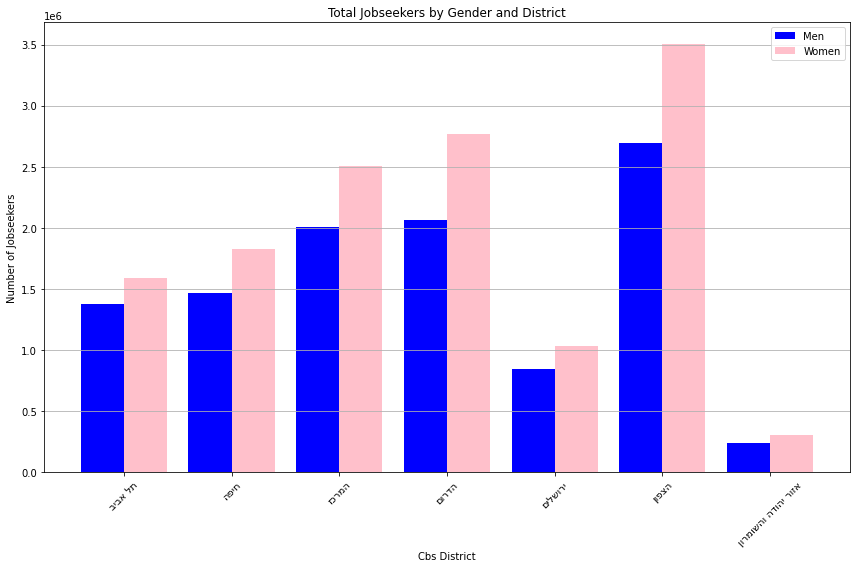

In [15]:
### CODE BY CHAT-GPT ###

text_replacements = {
    'הצפון': 'ןופצה', 
    'המרכז': 'זכרמה', 
    'הדרום': 'םורדה', 
    'תל אביב': 'ביבא לת',
    'חיפה' : 'הפיח',
    'ירושלים' : 'םילשורי',
    'אזור יהודה והשומרון' : 'ןורמושהו הדוהי רוזא'
}

df1['Cbs district'] = df1['Cbs district'].replace(text_replacements)

df_grouped = df1.groupby('Cbs district').agg({
    'Men': 'sum',
    'Women': 'sum'
}).reset_index()

x = range(len(df_grouped['Cbs district']))
width = 0.4  

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar([p - width/2 for p in x], df_grouped['Men'], width=width, label='Men', color='blue')
ax.bar([p + width/2 for p in x], df_grouped['Women'], width=width, label='Women', color='pink')

ax.set_xticks(x)
ax.set_xticklabels(df_grouped['Cbs district'], rotation=45) 
ax.set_title('Total Jobseekers by Gender and District')

####

ax.set_xlabel('Cbs District')
ax.set_ylabel('Number of Jobseekers')
ax.legend()

plt.grid(axis='y')
plt.tight_layout()  
plt.show()

The graph shows that women are seeking employment more than men across all regions, which may reflect a higher demand for women in the labor market or specific challenges they face. Additionally, the Northern district has a higher number of job seekers compared to other districts, suggesting more severe unemployment or unique economic challenges in that area.

### Scaling
To select the scaling method, we examined the distribution of the numerical columns.

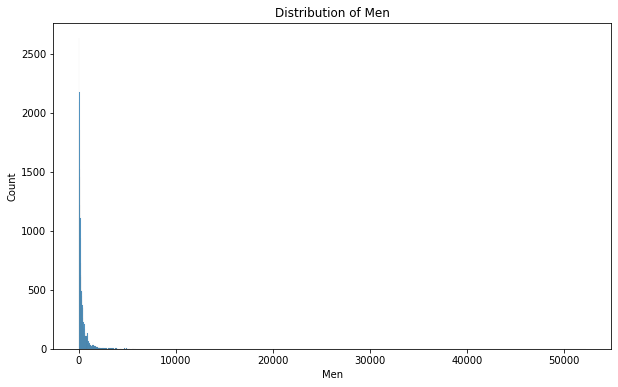

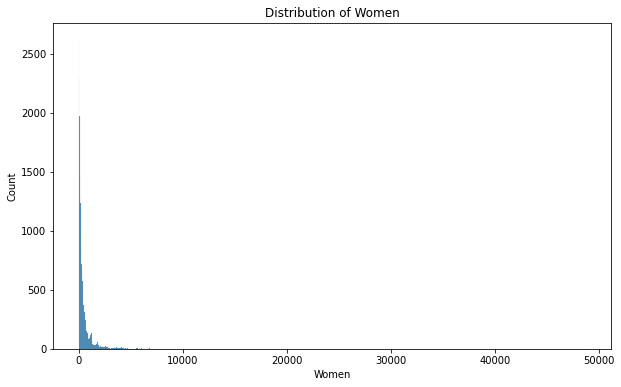

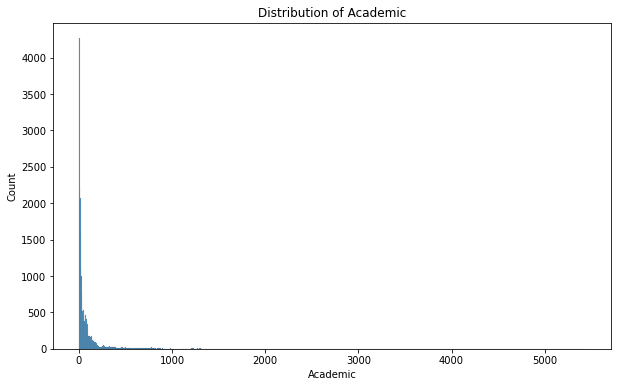

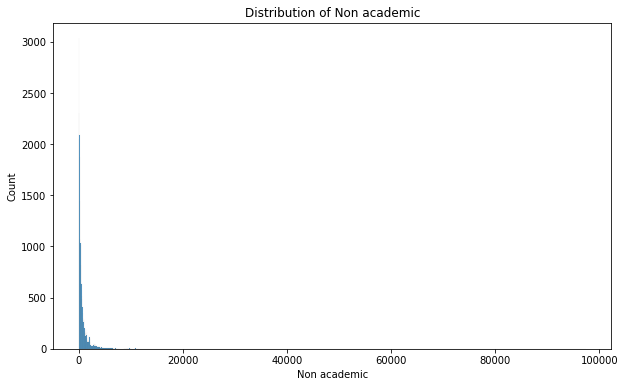

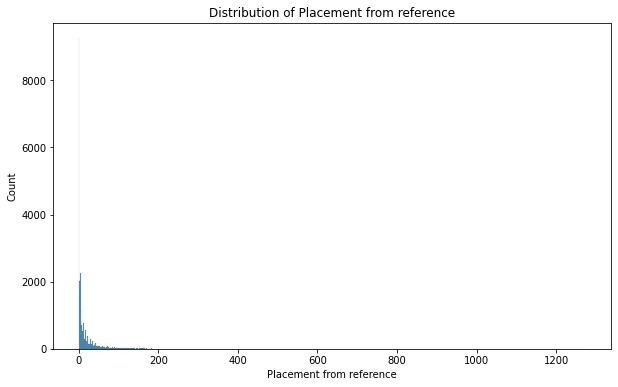

In [16]:
# Define features and target
X = df.drop(columns=['Month','Total jobseekers','Unemployed job seekers', 'Estimated unemployed rate in city', 'unemployment_rate_category'])
y = df['unemployment_rate_category']

numerical_features = ['Men', 'Women', 'Academic', 'Non academic', 'Placement from reference']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(X[feature], kde=False)
    plt.title(f"Distribution of {feature}")
    plt.savefig(f"distribution_{feature}.png")
    plt.show()

The distribution in the graph appears logarithmic or exponential, suggesting the need for a logarithmic scale.
Since we applied a logarithmic scale, it is appropriate to use a StandardScaler.

In [17]:
# Define categorical and numerical columns
categorical_features = ['Name','Cbs district', 'City or Regional council']
numerical_features = ['Men', 'Women', 'Academic', 'Non academic', 'Placement from reference']

# Pipeline 
numerical_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p)),  
    ('scale', StandardScaler())             
])
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

### statistics tests

In [18]:
X_train_processed = preprocessor.fit_transform(X_train)

X_train_processed_numerical = X_train_processed[:, :len(numerical_features)]

# ANOVA 

anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X_train_processed_numerical, y_train)

anova_scores = pd.DataFrame({
    'Feature': numerical_features,
    'ANOVA F-Statistic': anova_selector.scores_
})
anova_scores = anova_scores.sort_values(by='ANOVA F-Statistic', ascending=False)
print("חשיבות תכונות לפי ANOVA:")
print(anova_scores)

חשיבות תכונות לפי ANOVA:
                    Feature  ANOVA F-Statistic
3              Non academic        7021.235685
1                     Women        5238.866909
0                       Men        4413.054334
4  Placement from reference        3179.713817
2                  Academic        1745.773397


The ANOVA F-statistic values indicate that all numerical features show a significant relationship with the target variable (unemployment rate category), with "Non academic" and "Weman" exhibiting the highest F-statistics.

In [19]:
### CODE BY CHAT-GPT ###
# Chi-squared

X_train_cat = X_train[categorical_features]
X_train_cat_encoded = pd.DataFrame()

for column in X_train_cat.columns:
    le = LabelEncoder()
    X_train_cat_encoded[column] = le.fit_transform(X_train_cat[column])

chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_train_cat_encoded, y_train)

chi2_scores = pd.DataFrame({
    'Feature': categorical_features,
    'Chi-squared Statistic': chi2_selector.scores_
})

####

print("\nChi-squared Results:")
print(chi2_scores)


Chi-squared Results:
                    Feature  Chi-squared Statistic
0                      Name             819.465917
1              Cbs district             289.869049
2  City or Regional council            1950.115311


The Chi-squared statistics show that the categorical features "Name," "Cbs district," and "City or Regional council" have a strong association with the unemployment rate category.
The high Chi-squared values indicate that the distinctions between different cities, districts, and councils significantly influence the unemployment rate classification.

### PCA

In [20]:
encoder = OneHotEncoder(sparse=False)

encoded = encoder.fit_transform(X[categorical_features])

# Create a DataFrame from the encoded data with column names
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names(categorical_features))

# Reset index of the original DataFrame
df_reset = df.reset_index(drop=True)

# Concatenate the original DataFrame with the encoded DataFrame
df_concatenated = pd.concat([df_reset, df_encoded], axis=1)
# Drop the original columns from the concatenated DataFrame
df_concatenated_dropped = df_concatenated.drop(['Name','Cbs district', 'City or Regional council','Total jobseekers','Unemployed job seekers','unemployment_rate_category'], axis=1)

df_concatenated_dropped

,Month,Men,Women,Academic,Non academic,Placement from reference,Estimated unemployed rate in city,Name_אבו גוש,Name_אבו סנאן,Name_אבן יהודה,...,Name_תל שבע,Cbs district_אזור יהודה והשומרון,Cbs district_הדרום,Cbs district_המרכז,Cbs district_הצפון,Cbs district_חיפה,Cbs district_ירושלים,Cbs district_תל אביב,City or Regional council_יישוב,City or Regional council_מועצה איזורית
0,2010-01-01,34,49,36,47,2,2.22,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2010-01-01,38,50,26,62,4,2.18,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2010-01-01,12,8,9,11,2,1.19,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2010-01-01,28,20,18,30,5,1.37,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2010-01-01,189,221,111,299,16,4.12,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28615,2020-04-01,64,75,8,131,0,16.67,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
28616,2020-04-01,1713,2363,350,3726,1,20.71,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
28617,2020-04-01,9216,12417,1492,20141,8,26.37,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
28618,2020-04-01,2049,2921,351,4619,2,21.59,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [21]:
df_pca = df_concatenated_dropped

In [22]:
# Select columns that are not of object type
df_pca = df_pca.select_dtypes(exclude=['object','datetime64','category'])
df_pca.info()
df_pca.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28620 entries, 0 to 28619
Columns: 274 entries, Men to City or Regional council_מועצה איזורית
dtypes: float64(269), int64(5)
memory usage: 59.8 MB


,Men,Women,Academic,Non academic,Placement from reference,Estimated unemployed rate in city,Name_אבו גוש,Name_אבו סנאן,Name_אבן יהודה,Name_אום אל-פחם,...,Name_תל שבע,Cbs district_אזור יהודה והשומרון,Cbs district_הדרום,Cbs district_המרכז,Cbs district_הצפון,Cbs district_חיפה,Cbs district_ירושלים,Cbs district_תל אביב,City or Regional council_יישוב,City or Regional council_מועצה איזורית
0,34,49,36,47,2,2.22,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,38,50,26,62,4,2.18,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,12,8,9,11,2,1.19,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,28,20,18,30,5,1.37,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,189,221,111,299,16,4.12,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Number of components: 1, Explained variance sum: 0.0182
Number of components: 2, Explained variance sum: 0.0295
Number of components: 3, Explained variance sum: 0.0391
Number of components: 4, Explained variance sum: 0.0473
Number of components: 5, Explained variance sum: 0.0552
Number of components: 6, Explained variance sum: 0.0629
Number of components: 7, Explained variance sum: 0.0704
Number of components: 8, Explained variance sum: 0.0774
Number of components: 9, Explained variance sum: 0.0827
Number of components: 10, Explained variance sum: 0.0866
Number of components: 11, Explained variance sum: 0.0903
Number of components: 12, Explained variance sum: 0.0940
Number of components: 13, Explained variance sum: 0.0976
Number of components: 14, Explained variance sum: 0.1013
Number of components: 15, Explained variance sum: 0.1050


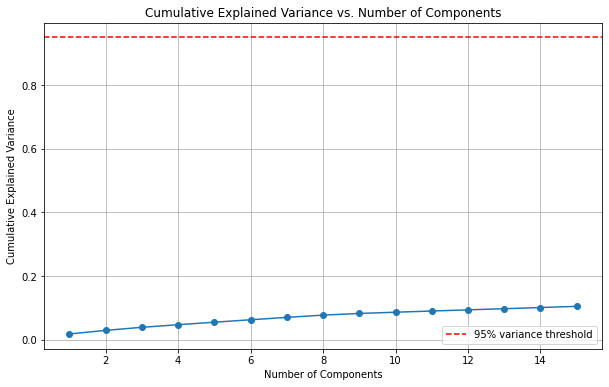

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)
pca = PCA(n_components=15, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_sum = np.cumsum(explained_variance_ratio)

for n_components, explained_variance in enumerate(explained_variance_sum, start=1):
    print(f"Number of components: {n_components}, Explained variance sum: {explained_variance:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), explained_variance_sum, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% variance threshold")  # Optional: Add a threshold line
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend(loc="best")
plt.show()

PCA is not suitable in this case because the cumulative explained variance does not approach the desired threshold (e.g., 95%), even with a high number of components, indicating that dimensionality reduction does not retain enough important information. This suggests that the data may not be suitable for this method.

### Model

#### Logistic Regression - 
Logistic Regression assumes a linear relationship between the features and the log-odds of the target variable. It is highly interpretable and efficient for binary classification tasks, especially with clean and well-scaled data. However, it struggles with non-linear relationships and is sensitive to outliers and multicollinearity.
#### Random Forest - 
Random Forest is an ensemble model that builds multiple decision trees and combines their outputs for robust predictions.
It handles complex, non-linear relationships well and is resistant to overfitting due to feature randomness and averaging.
Despite its accuracy, it can be computationally expensive and less interpretable compared to simpler models.
#### XGBoost -
XGBoost is a gradient boosting algorithm known for its speed and efficiency in large datasets.
It excels in handling non-linear patterns and imbalanced datasets while offering advanced hyperparameter tuning options.
However, it is sensitive to overfitting without proper regularization and requires careful parameter optimization.
#### Support Vector Machine (SVM) -
SVM aims to find the optimal hyperplane that separates data points into distinct classes, even in high-dimensional spaces.
It can handle non-linear relationships using kernel functions and is effective for small to medium-sized datasets.
SVMs are computationally intensive for large datasets and less interpretable compared to simpler models.
#### K-Nearest Neighbors (KNN) -
KNN classifies data based on the majority label of the nearest neighbors in feature space.
It is simple to implement and performs well on non-linear problems with balanced and scaled data.
KNN can be slow on large datasets and is sensitive to noise and outliers, requiring careful preprocessing.

In [24]:
### CODE BY CHAT-GPT ###
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Define parameter grids for hyperparameter search
param_grids = {
    'Logistic Regression': {
        'model__C': [0.1, 1.0, 10.0],
        'model__solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30]
    },
    'XGBoost': {
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 5, 7]
    },
    'SVM': {
        'model__C': [0.1, 1.0, 10.0],
        'model__kernel': ['linear', 'rbf']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    }
}

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    param_grid = param_grids.get(name, {})
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)
    results[name] = {
        'mean_auc': grid_search.best_score_,
        'std_auc': grid_search.cv_results_['std_test_score'][grid_search.best_index_],
        'best_params': grid_search.best_params_
    }

for model, scores in results.items():
    print(f"{model}: Mean AUC = {scores['mean_auc']:.4f}, Std AUC = {scores['std_auc']:.4f}")
    print(f"Best Params: {scores['best_params']}")

best_model_name = max(results, key=lambda x: results[x]['mean_auc'])
print(f"Best Model: {best_model_name}")

best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[best_model_name])])
best_pipeline.set_params(**results[best_model_name]['best_params'])
best_pipeline.fit(X_train, y_train)

####

# Predictions
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1) 
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

Logistic Regression: Mean AUC = 0.9955, Std AUC = 0.0014
Best Params: {'model__C': 10.0, 'model__solver': 'liblinear'}
Random Forest: Mean AUC = 0.9961, Std AUC = 0.0016
Best Params: {'model__max_depth': 30, 'model__n_estimators': 200}
XGBoost: Mean AUC = 0.9943, Std AUC = 0.0023
Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 100}
SVM: Mean AUC = 0.9957, Std AUC = 0.0013
Best Params: {'model__C': 10.0, 'model__kernel': 'linear'}
KNN: Mean AUC = 0.9887, Std AUC = 0.0054
Best Params: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Best Model: Random Forest
Accuracy: 0.9542, F1-Score: 0.9452, ROC-AUC: 0.9917


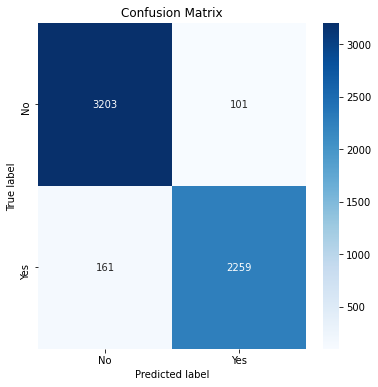

In [25]:
# Confusion Matrix
c_m = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(c_m, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

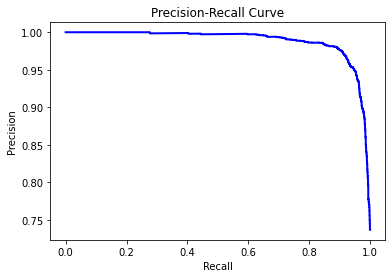

In [26]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig('Precision_Recall_Curve.png')
plt.show()

The graph shows the Precision-Recall curve for the model. It indicates that the model maintains a very high precision when recall is low, but as recall increases, the precision drops significantly, especially at higher recall values.

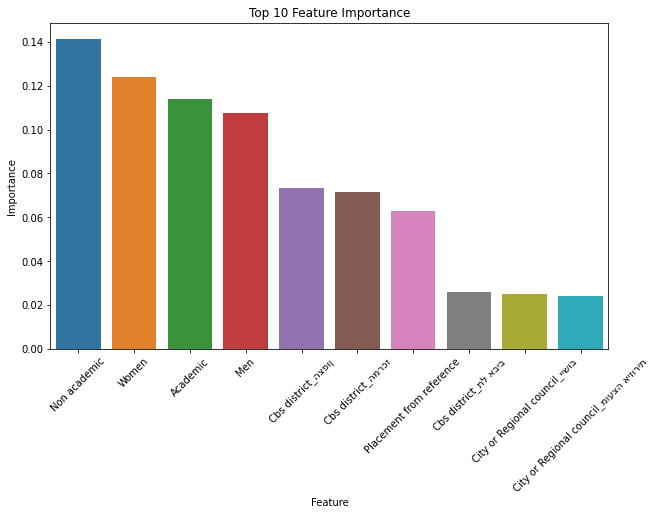

In [27]:
# Feature importance
if isinstance(best_pipeline.named_steps['model'], RandomForestClassifier):
    feature_importances = best_pipeline.named_steps['model'].feature_importances_
    feature_names = numerical_features + list(preprocessor.transformers_[1][1].get_feature_names(categorical_features))
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
top_10_importance_df = importance_df.head(10)
    
plt.figure(figsize=(10, 6))
sns.barplot(y='Importance', x='Feature', data=top_10_importance_df)
plt.title('Top 10 Feature Importance')
plt.xticks(rotation=45)
plt.savefig('feature_importance.png')
plt.show()

### Anomaly detection 

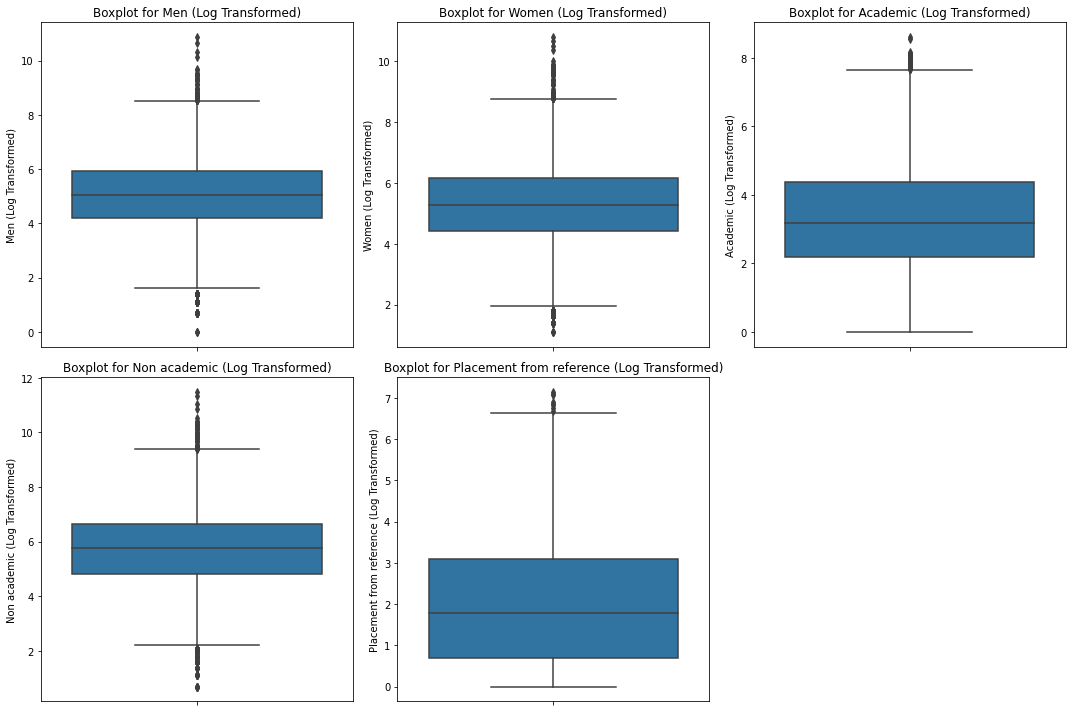

In [28]:
df_anomaly = df.copy()
numerical_features = ['Men', 'Women', 'Academic', 'Non academic', 'Placement from reference']

for feature in numerical_features:
    df_anomaly[feature + '_log'] = np.log1p(df_anomaly[feature])  # Log Transformation

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df_anomaly[feature + '_log'])
    plt.title(f'Boxplot for {feature} (Log Transformed)')
    plt.ylabel(feature + ' (Log Transformed)')

plt.tight_layout()
plt.savefig('boxplots.png')
plt.show()

From the graphs, we can see that there are many outliers. This could explain the difference between very large cities like Jerusalem and Haifa compared to other localities.

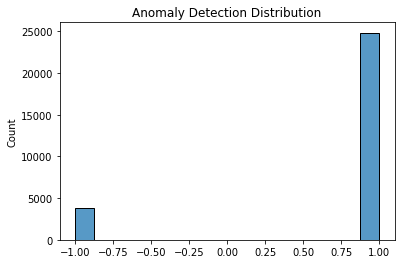

In [29]:
# Anomaly Detection
X_anomaly = df[numerical_features]
anomaly_model = IsolationForest(random_state=42)
anomaly_labels = anomaly_model.fit_predict(X_anomaly)

sns.histplot(anomaly_labels, kde=False)
plt.title("Anomaly Detection Distribution")
plt.savefig('Anomaly_Detection_Distribution.png')
plt.show()

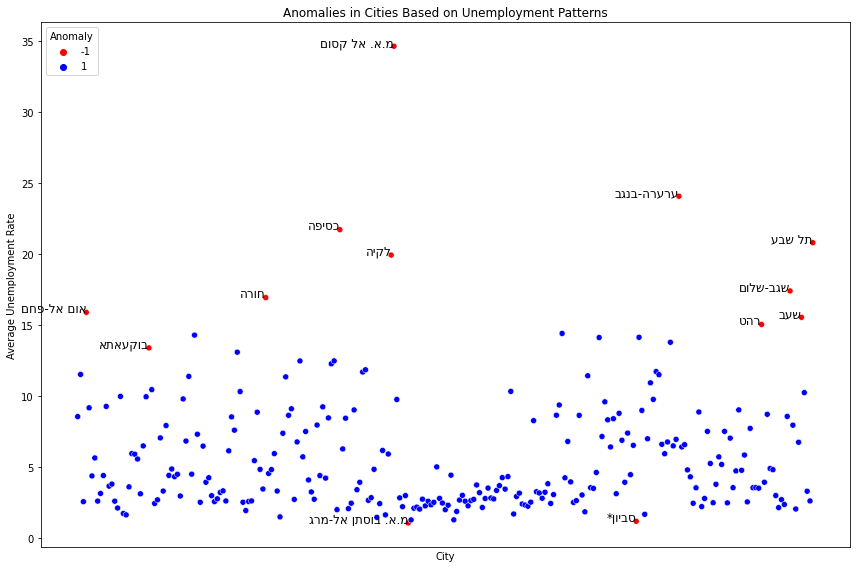

Cities with unusual unemployment patterns:
                  Name  Avg Unemployment Rate
3           אום אל-פחם              15.895403
25             בוקעאתא              13.391452
66                חורה              16.934194
92               כסיפה              21.722984
110               לקיה              19.934919
111       מ.א. אל קסום              34.652763
116  מ.א. בוסתן אל-מרג               1.050192
196             סביון*               1.170565
211         ערערה-בנגב              24.079677
240                רהט              15.042903
250           שגב-שלום              17.404194
254                שעב              15.546452
258             תל שבע              20.805242


In [30]:
city_data = df.groupby('Name')['Estimated unemployed rate in city'].mean().reset_index()
city_data.rename(columns={'Estimated unemployed rate in city': 'Avg Unemployment Rate'}, inplace=True)

scaler = StandardScaler()
city_data['Normalized Unemployment Rate'] = scaler.fit_transform(city_data[['Avg Unemployment Rate']])

anomaly_model = IsolationForest(random_state=42, contamination=0.05) 
city_data['Anomaly'] = anomaly_model.fit_predict(city_data[['Normalized Unemployment Rate']])

anomalies = city_data[city_data['Anomaly'] == -1]
normal_cities = city_data[city_data['Anomaly'] == 1]

### CODE BY CHAT-GPT ###

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=city_data, 
    x='Name', 
    y='Avg Unemployment Rate', 
    hue='Anomaly', 
    palette={1: 'blue', -1: 'red'}
)

for _, row in anomalies.iterrows():
    plt.text(
        row['Name'], 
        row['Avg Unemployment Rate'],
        row['Name'][::-1],
        horizontalalignment='right', 
        fontsize=12, 
        color='black'
    )

####
    
plt.title("Anomalies in Cities Based on Unemployment Patterns")
plt.xlabel("City")
plt.ylabel("Average Unemployment Rate")
plt.xticks([], [])
plt.legend(title="Anomaly", loc='upper left')
plt.tight_layout()
plt.savefig('Anomalies.png')
plt.show()

print("Cities with unusual unemployment patterns:")
print(anomalies[['Name', 'Avg Unemployment Rate']])

### Clustering

#### K-Means
#### Finding the optimal number of clusters:

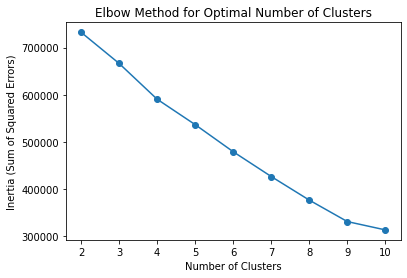

,Clusters,SSE,Silhouette,Sample Count,Min Count,Max Count
0,2,732391.588459,0.206695,"1 24516 0 4104 Name: count, dtype: int64",4104,24516
1,3,666401.333042,0.197811,"0 17498 1 7018 2 4104 Name: count, ...",4104,17498
2,4,590590.616648,0.172308,0 14482 1 8921 3 4104 2 1113 Na...,1113,14482
3,5,536777.213825,0.183993,0 17570 1 4838 2 4104 4 1294 3 ...,814,17570
4,6,479373.654911,0.253501,3 11984 0 7310 2 4104 4 3050 5 ...,878,11984
5,7,426851.127097,0.286731,1 12475 3 4838 2 3648 0 3050 5 ...,811,12475
6,8,376908.157970,0.329183,0 10567 1 5748 4 3790 5 3354 2 ...,571,10567
7,9,331474.757381,0.342918,1 9427 4 4847 0 3508 2 3050 5 2...,571,9427
8,10,313846.558360,0.343029,1 9422 4 4572 2 3952 5 3050 7 2...,150,9422


In [31]:
def cluster_and_evaluate(data, cluster_range=[2, 3, 4, 5, 6, 7, 8, 9, 10]):
    
    results_df = pd.DataFrame(columns=['Clusters', 'SSE', 'Silhouette', 'Sample Count', 'Min Count', 'Max Count'])
    elbow_df = pd.DataFrame(columns=['Clusters', 'Inertia'])

    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        kmeans.fit(data)
        labels = kmeans.labels_
        sample_count = pd.Series(labels).value_counts()

        sse = kmeans.inertia_
        silhouette_avg = silhouette_score(data, labels)

        results_df = pd.concat([results_df, pd.DataFrame({'Clusters': [num_clusters], 'SSE': [sse], 'Silhouette': [silhouette_avg], 'Sample Count': [sample_count], 'Min Count': [sample_count.min()], 'Max Count': [sample_count.max()]})], ignore_index=True)
        elbow_df = pd.concat([elbow_df, pd.DataFrame({'Clusters': [num_clusters], 'Inertia': [sse]})], ignore_index=True)

    plt.plot(elbow_df['Clusters'], elbow_df['Inertia'], marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia (Sum of Squared Errors)')
    plt.savefig('Elbow_Optimal_Clusters.png')
    plt.show()

    return results_df

results = cluster_and_evaluate(X_pca)
results


According to the silhouette score, clusters 9 and 10 are very close, but based on the graph, it seems that cluster 9 is more suitable. We will conduct another test.

Best k for alpha_k=0.02: 11
Best k for alpha_k=0.03: 9
Best k for alpha_k=0.04: 9
Best k for alpha_k=0.05: 9


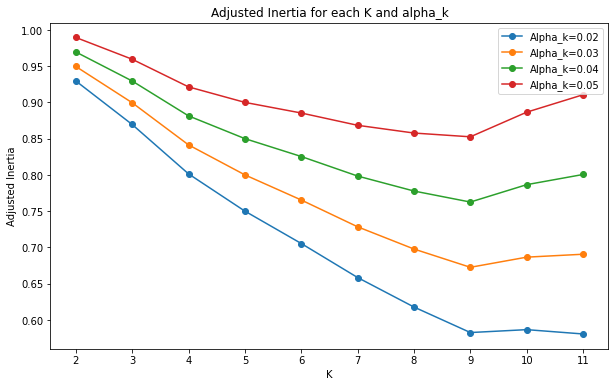

In [32]:
def kMeansRes(scaled_data, k, alpha_k):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range, alpha_k_values):
    results_list = []
    for alpha_k in alpha_k_values:
        ans = []
        for k in k_range:
            scaled_inertia = kMeansRes(scaled_data, k, alpha_k)
            ans.append((k, scaled_inertia))
        results = pd.DataFrame(ans, columns=['k', f'Alpha_k={alpha_k}']).set_index('k')
        results_list.append(results)

    best_ks = [results.idxmin()[0] for results in results_list]
    return best_ks, results_list

scaled_data = np.asarray(X_pca).astype(float)
k_range = range(2, 12)
alpha_k_values = [0.02, 0.03, 0.04, 0.05]

best_ks, results_list = chooseBestKforKMeans(scaled_data, k_range, alpha_k_values)

for alpha_k, best_k in zip(alpha_k_values, best_ks):
    print(f"Best k for alpha_k={alpha_k}: {best_k}")

plt.figure(figsize=(10, 6))
for i, results in enumerate(results_list):
    plt.plot(results, 'o-', label=f"Alpha_k={alpha_k_values[i]}")
plt.title('Adjusted Inertia for each K and alpha_k')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.xticks(range(2, 12, 1))
plt.legend()
plt.savefig('Adjusted_Inertia_k.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.2066947479836922
For n_clusters = 3 The average silhouette_score is : 0.19781122846979401
For n_clusters = 4 The average silhouette_score is : 0.17230805822162634
For n_clusters = 5 The average silhouette_score is : 0.18399254757086775
For n_clusters = 6 The average silhouette_score is : 0.2535009682038804
For n_clusters = 7 The average silhouette_score is : 0.2867306119216349
For n_clusters = 8 The average silhouette_score is : 0.3291834326655646
For n_clusters = 9 The average silhouette_score is : 0.3429180465282997
For n_clusters = 10 The average silhouette_score is : 0.343028547557562


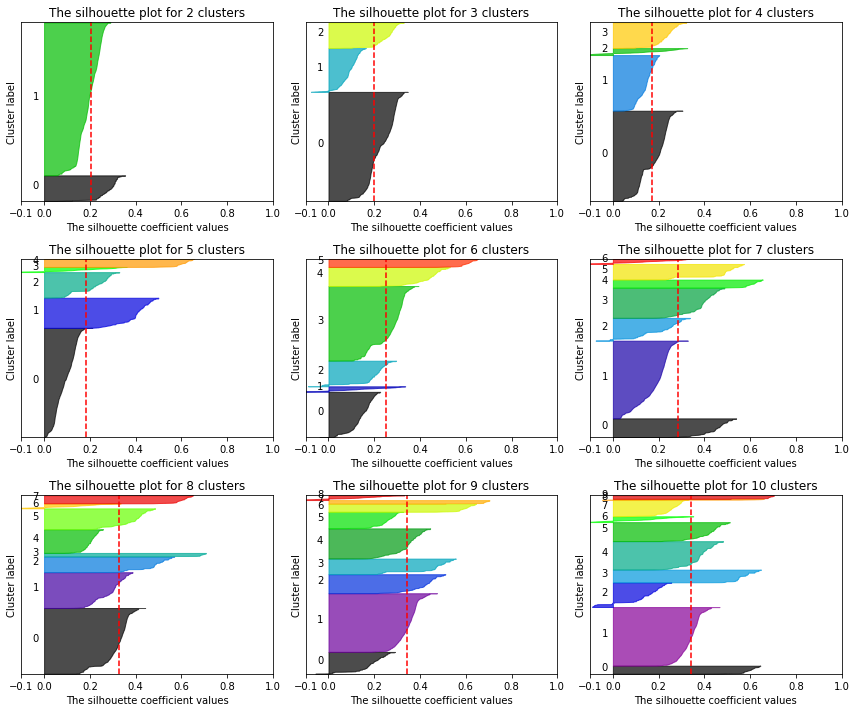

,num_of_clusters,SSE,silhouette_avg,num_of_samples,Max,Min,samples_per_cluster
0,2,732391.588459,0.206695,28620,24516,4104,"{0: 4104, 1: 24516}"
1,3,666401.333042,0.197811,28620,17498,4104,"{0: 17498, 1: 7018, 2: 4104}"
2,4,590590.616648,0.172308,28620,14482,1113,"{0: 14482, 1: 8921, 2: 1113, 3: 4104}"
3,5,536777.213825,0.183993,28620,17570,814,"{0: 17570, 1: 4838, 2: 4104, 3: 814, 4: 1294}"
4,6,479373.654911,0.253501,28620,11984,878,"{0: 7310, 1: 878, 2: 4104, 3: 11984, 4: 3050, ..."
5,7,426851.127097,0.286731,28620,12475,811,"{0: 3050, 1: 12475, 2: 3648, 3: 4838, 4: 1294,..."
6,8,376908.157970,0.329183,28620,10567,571,"{0: 10567, 1: 5748, 2: 2504, 3: 571, 4: 3790, ..."
7,9,331474.757381,0.342918,28620,9427,571,"{0: 3508, 1: 9427, 2: 3050, 3: 2504, 4: 4847, ..."
8,10,313846.558360,0.343029,28620,9422,150,"{0: 1294, 1: 9422, 2: 3952, 3: 2048, 4: 4572, ..."


In [33]:
### CODE BY CHAT-GPT ###

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

res_df = pd.DataFrame(columns=['num_of_clusters', 'SSE', 'silhouette_avg', 'num_of_samples', 'Max', 'Min', 'samples_per_cluster'])

fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for n_clusters, ax in zip(range_n_clusters, axes.flatten()):
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(X_pca)
    cluster_labels = clusterer.labels_

    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    sse = clusterer.inertia_

    y_lower = 10
    cluster_samples = {}
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

        cluster_samples[i] = size_cluster_i

    ax.set_title(f"The silhouette plot for {n_clusters} clusters")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the y-axis labels/ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Collect results into the DataFrame
    sumple_count = np.bincount(cluster_labels)
    res_df = pd.concat([res_df, pd.DataFrame([{'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,
                                            'num_of_samples': sumple_count.sum(), 'Max': sumple_count.max(),
                                            'Min': sumple_count.min(), 'samples_per_cluster': cluster_samples}])],
                    ignore_index=True)

plt.tight_layout()
plt.savefig('silhouette.png')
plt.show()

####

res_df

The graphs show the Silhouette analysis for different clusterings, with the average Silhouette score (red dashed line) indicating the quality of separation between clusters. Based on the results, a 9-cluster solution was chosen as the optimal one, achieving the highest average Silhouette score (0.330).

          0         1         2         3         4         5         6  \
0 -1.131373 -0.252599 -1.822003 -0.929977  2.761019 -2.225146  1.684938   
1 -1.134452 -0.256171 -1.818277 -0.929287  2.763413 -2.229709  1.697963   
2 -1.248553 -0.236715 -1.906396 -0.895326  2.752413 -2.236092  1.679488   
3 -1.189918 -0.222062 -1.919544 -0.866487  2.754512 -2.189690  1.676455   
4 -0.621119 -0.233840 -1.622698 -0.956535  2.758018 -2.297230  1.630033   

          7         8         9        10        11        12        13  \
0  1.765983  0.018556  0.027123 -0.016058 -0.832197 -0.974820  0.485410   
1  1.765944 -0.077721 -0.914708 -0.278558 -1.444044  0.001480  1.000371   
2  1.755027 -0.016128 -0.446736  1.592431  0.592442 -0.683065 -0.728143   
3  1.831394 -0.557202 -0.405042 -1.675003 -0.910606  1.570245 -1.350263   
4  1.759869  0.621172 -0.444733  0.005192 -0.127023 -0.323895 -0.596771   

         14  cluster  
0  0.600886        3  
1  1.422018        3  
2  0.986042        3  
3  0.7

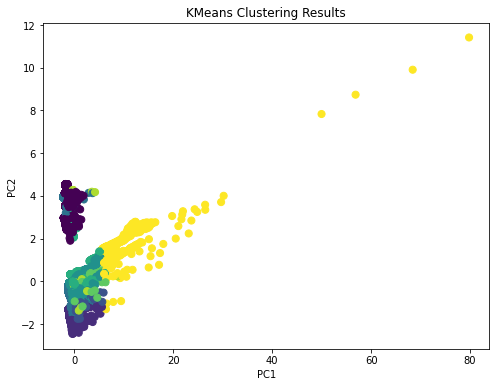

In [34]:
n_clusters_optimal = 9  

kmeans = KMeans(n_clusters=n_clusters_optimal, random_state=42, n_init=10)
kmeans.fit(X_pca)  

X_pca_df = pd.DataFrame(X_pca)  
X_pca_df['cluster'] = kmeans.labels_  

print(X_pca_df.head())

print(f'Centroids of the clusters:\n{kmeans.cluster_centers_}')
print(f'Inertia (SSE): {kmeans.inertia_}')

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_df[0], X_pca_df[1], c=X_pca_df['cluster'], cmap='viridis', s=50)
plt.title('KMeans Clustering Results')
plt.xlabel('PC1')  
plt.ylabel('PC2')
plt.savefig('KMeans_Clustering_Results.png')
plt.show()


#### DBSCAN 

In [35]:
clustering_data = df.copy()
clustering_data.head()

,Month,Cbs district,Name,City or Regional council,Total jobseekers,Men,Women,Academic,Non academic,Unemployed job seekers,Placement from reference,Estimated unemployed rate in city,unemployment_rate_category
0,2010-01-01,אזור יהודה והשומרון,אורנית,יישוב,83,34,49,36,47,83,2,2.22,0
1,2010-01-01,אזור יהודה והשומרון,אלפי מנשה,יישוב,88,38,50,26,62,88,4,2.18,0
2,2010-01-01,אזור יהודה והשומרון,אלקנה,יישוב,20,12,8,9,11,20,2,1.19,0
3,2010-01-01,אזור יהודה והשומרון,אפרתה,יישוב,48,28,20,18,30,48,5,1.37,0
4,2010-01-01,אזור יהודה והשומרון,אריאל,יישוב,410,189,221,111,299,410,16,4.12,0


In [36]:
city_avg = clustering_data.groupby('Name')['Estimated unemployed rate in city'].mean()
region_avg = clustering_data.groupby('Cbs district')['Estimated unemployed rate in city'].mean()

clustering_data['City_Encoded'] = clustering_data['Name'].map(city_avg)
clustering_data['Region_Encoded'] = clustering_data['Cbs district'].map(region_avg)

encoded_data = clustering_data.drop(columns=['Month', 'Cbs district','Name', 'City or Regional council', 'unemployment_rate_category'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_data)

dbscan = DBSCAN(eps=2.0, min_samples=5)
labels = dbscan.fit_predict(scaled_data)

clustering_data['Cluster'] = labels
clustering_data_filtered = clustering_data[clustering_data['Cluster'] != -1] 

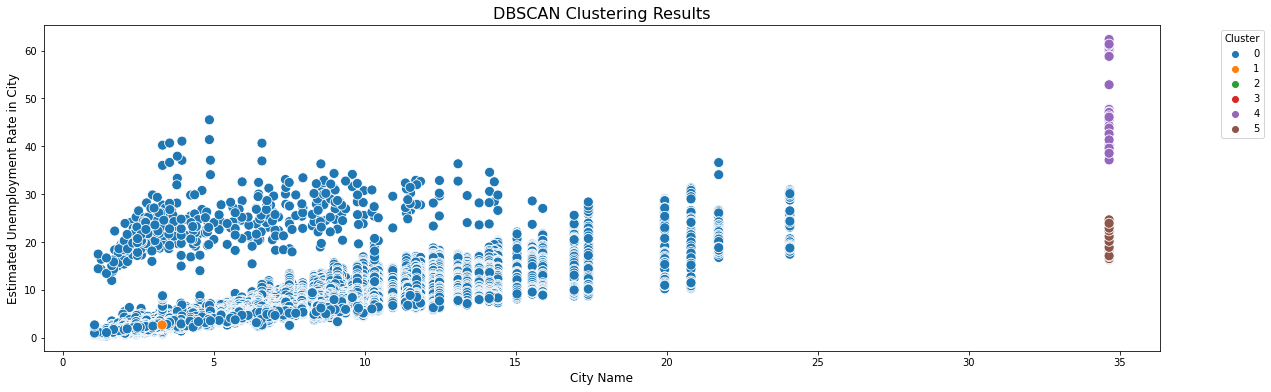

In [37]:
plt.figure(figsize=(20, 6))
sns.scatterplot(data=clustering_data_filtered, x='City_Encoded', y='Estimated unemployed rate in city', hue='Cluster', palette='tab10', legend='full', s=100, marker='o')

plt.title("DBSCAN Clustering Results", fontsize=16)
plt.xlabel("City Name", fontsize=12)
plt.ylabel("Estimated Unemployment Rate in City", fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('DBSCAN_Clustering_Results.png')
plt.show()

#### Hierarchical clustering

#### Ward Linkage:
This method minimizes the total variance within each cluster. At each step, it merges the two clusters that result in the smallest increase in total within-cluster variance.

#### Complete Linkage:
This method focuses on the maximum distance between points in two clusters being merged. It ensures that the clusters connected are the most tightly bound in terms of maximum distance.

#### Average Linkage:
This method calculates the average distance between all points in two clusters being merged. It balances between small and large distances when forming clusters.

#### Single Linkage:
This method is based on the shortest distance between two points from different clusters. It often results in closely connected clusters but can lead to a "chaining effect."

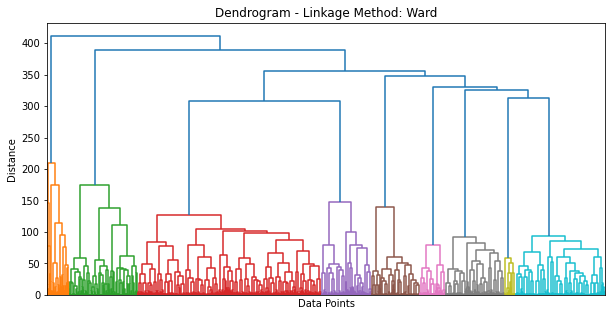

Cluster labels using Ward linkage:
[22168 24625 21200 ...     2     1     0]



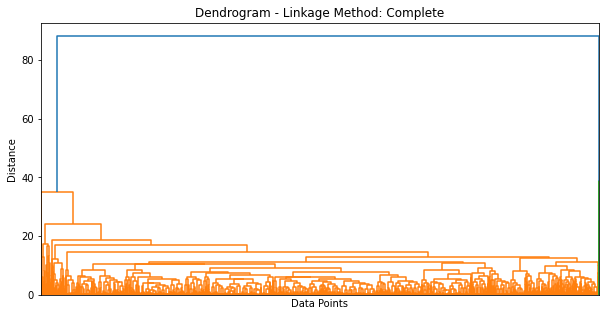

Cluster labels using Complete linkage:
[22047 24573 17712 ...     1     2     0]



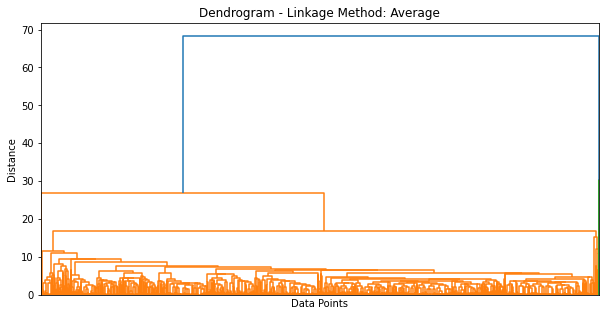

Cluster labels using Average linkage:
[21411 24262 14483 ...     1     2     0]



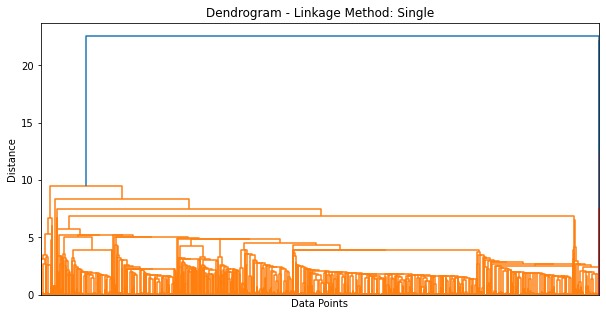

Cluster labels using Single linkage:
[19379 23123 22467 ...     2     1     0]



In [38]:
def compare_agglomerative_clustering(data_array):
    data_frame = pd.DataFrame(data_array)

    linkage_methods = ['ward', 'complete', 'average', 'single']

    for method in linkage_methods:
        Z = linkage(data_frame.values, method)

        plt.figure(figsize=(10, 5))
        dendrogram(Z, labels=data_frame.index, orientation='top', leaf_rotation=90, leaf_font_size=8)
        plt.title(f'Dendrogram - Linkage Method: {method.capitalize()}')
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis tick labels
        plt.show()
        
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage=method, distance_threshold=0)
        cluster_labels = cluster.fit_predict(data_frame.values)

        print(f'Cluster labels using {method.capitalize()} linkage:\n{cluster_labels}\n{"="*40}\n')

compare_agglomerative_clustering(X_pca)

#### Ward Linkage:
This method created clear and well-separated clusters. The gradual merging of clusters makes it the most suitable method for this dataset.

#### Complete Linkage:
The clusters were merged at large distances, making it difficult to identify clear groups. This method may not be the best fit for the data.

#### Average Linkage:
The clustering was relatively balanced, but the clusters were less distinct compared to Ward Linkage. This method could be a reasonable alternative if a more moderate approach is needed.

#### Single Linkage:
This method formed very tight connections at the start, leading to a "chaining effect" that makes it hard to identify clear clusters. It is not well-suited for the goal of creating distinct clusters.

In [39]:
ward_method = sch.linkage(X_pca, method="ward", metric="euclidean")

Text(0, 0.5, 'Variation in cluster distance')

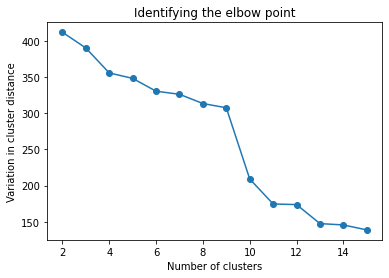

In [40]:
distances = ward_method[-14:, 2]
num_clusters = np.arange(len(distances) + 1, 1, -1)
plt.plot(num_clusters, distances, marker='o')
plt.title('Identifying the elbow point')
plt.xlabel('Number of clusters')
plt.ylabel('Variation in cluster distance')

In [41]:
hc = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')
y_pc_hc = hc.fit_predict(X_pca)
X_pc_hc = pd.DataFrame(X_pca)
X_pc_hc['cluster'] = y_pc_hc
X_pc_hc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,cluster
0,-1.131373,-0.252599,-1.822003,-0.929977,2.761019,-2.225146,1.684938,1.765983,0.018556,0.027123,-0.016058,-0.832197,-0.974820,0.485410,0.600886,4
1,-1.134452,-0.256171,-1.818277,-0.929287,2.763413,-2.229709,1.697963,1.765944,-0.077721,-0.914708,-0.278558,-1.444044,0.001480,1.000371,1.422018,4
2,-1.248553,-0.236715,-1.906396,-0.895326,2.752413,-2.236092,1.679488,1.755027,-0.016128,-0.446736,1.592431,0.592442,-0.683065,-0.728143,0.986042,4
3,-1.189918,-0.222062,-1.919544,-0.866487,2.754512,-2.189690,1.676455,1.831394,-0.557202,-0.405042,-1.675003,-0.910606,1.570245,-1.350263,0.714009,4
4,-0.621119,-0.233840,-1.622698,-0.956535,2.758018,-2.297230,1.630033,1.759869,0.621172,-0.444733,0.005192,-0.127023,-0.323895,-0.596771,-0.473500,4


#### Calculation and Comparison of Silhouette Scores for Different Clustering Algorithms (K-Means, Hierarchical, DBSCAN):

In [42]:
kmeans_silhouette = silhouette_score(X_pca_df, kmeans.labels_)
hc_silhouette = silhouette_score(X_pc_hc, y_pc_hc)
if len(set(labels)) > 1:  
    score = silhouette_score(scaled_data, labels)
else:
    print("Only one cluster was found.")

    
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"Hierarchical Clustering Silhouette Score: {hc_silhouette}")
print(f"DBSCAN Silhouette Score: {score}")



K-Means Silhouette Score: 0.39125510940928965
Hierarchical Clustering Silhouette Score: 0.40963205425356075
DBSCAN Silhouette Score: 0.599386118634308


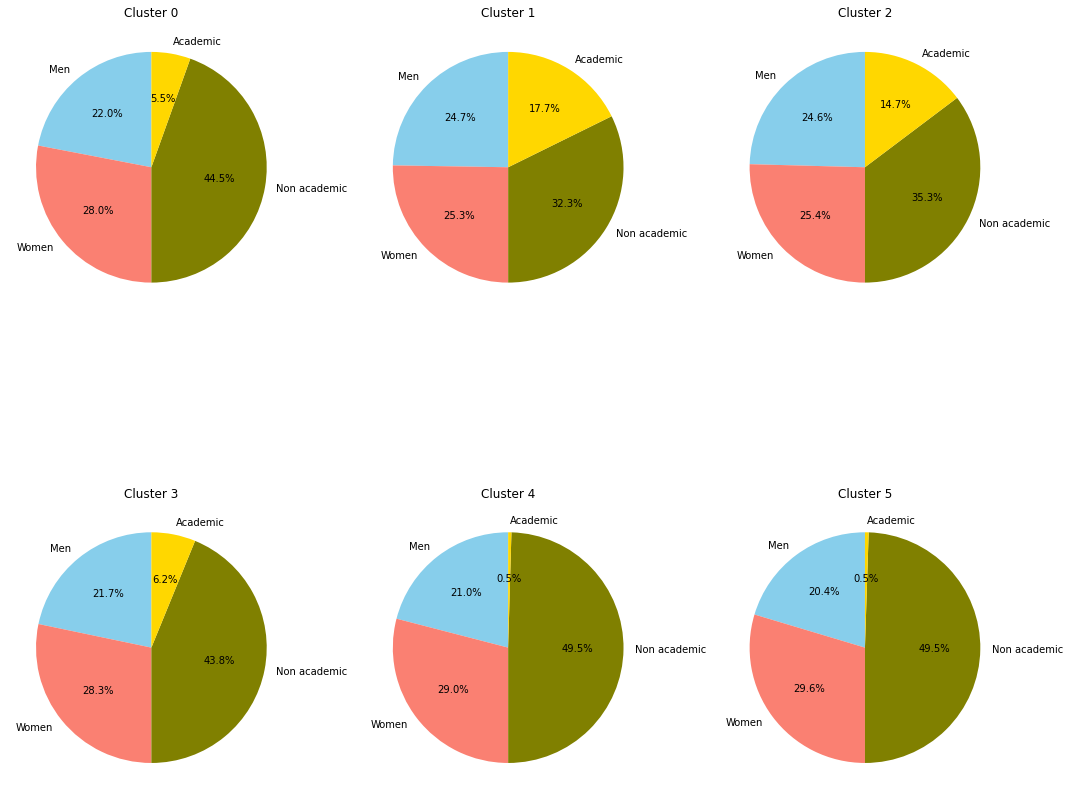

In [45]:
### CODE BY CHAT-GPT ###

# Group by cluster and calculate mean for each feature
data_viz = clustering_data_filtered.groupby('Cluster')[['Men', 'Women', 'Non academic', 'Academic']].mean()

# Define the number of clusters
clusters = data_viz.index
num_clusters = len(clusters)

# Create a larger figure for the grid
fig, axes = plt.subplots(2, 3, figsize=(15, 5 * 3))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot pie charts for each cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    ax.pie(
        data_viz.loc[cluster], 
        labels=data_viz.columns, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=['skyblue', 'salmon', 'olive', 'gold'],
        textprops={'fontsize': 10}  # Adjust font size for better readability
    )
    ax.set_title(f'Cluster {cluster}', fontsize=12)  # Add title for each chart

# Hide unused subplots
for j in range(len(clusters), len(axes)):
    axes[j].axis('off')

# Tighten layout
plt.tight_layout()
plt.show()